# Parameters
in this cell the used variables can be changed 

height and width correspond to the dimensions of the Workspace, in which the Topology Optimisation is going to be performed

log_dir is the direction where the current best Model will be saved to during training

ts is the amount of timesteps the model will be trained for




In [2]:
import os
import time

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import autograd.numpy as anp
import scipy

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor


In [3]:
# Here are the parameter for the Optimization

# DESIGN SPACE PARAMETERS

height = 15                             # The height of the design space
width = 30                              # The width of the design space                   
number_of_nodes = height * width        # The number of nodes in the design space
bound_nodes_list = [(0, 0), (0, -1)]    # A list containing the coordinates of 
                                        # the bounded nodes


# PHYSICAL PARAMETERS FOR THE FEM ANALYSIS

filter_width = 1
penal = 3.0
young_min = 1e-9
young = 1
poisson = 0.3
density = 1e-4
constraint_thresh = 0.7


# TECHNICAL PARAMETERS FOR THE REINFORCEMENT LEARNING

number_subprocesses = 8     # The number of Threads to be used during the 
                            # learning process

log_dir = "log/"            # The directory of where to save the best model

ts = 5e6                    # The number of timesteps to be used during the 
                            # learning process



# This is for the used FEM analysis taken from the Gigala repository
# it saves the boundary nodes in a 3D array where the first two dimensions are 
# the coordinates of the node and the third dimension is the direction of the normal
normals = np.zeros((height + 1, width + 1, 2))
x = 0
y = 1
for coords in bound_nodes_list:
    normals[coords[x], coords[y], x] = 1
    normals[coords[x], coords[y], y] = 1




forces = np.zeros((height + 1, width + 1, 2))
forces[-1, -1, y] = -1
forces = forces.ravel()



fixdofs = np.flatnonzero(normals.ravel())
alldofs = np.arange(2 * (normals.shape[0]) * (normals.shape[1]))
freedofs = np.sort(list(set(alldofs) - set(fixdofs)))





path_calculix = "E:/Bachelorarbeit/CalculiX/bConverged/CalculiX/ccx"





Here the reward for each state of the workspace is the compliance
which should be minimized or above a certain threshold



In [4]:
def objective(x, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=penal, e_min=young_min, e_0=young)
    x_phys = physical_density(x, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(young, poisson)  # stiffness matrix
    u      = displace(x_phys, ke, forces, freedofs, fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [5]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()

    return scipy.sparse.linalg.splu(a).solve



# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp


def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])


def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)


    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]






def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x,volume_contraint=False, use_filter=True):
    x = 1 * x.reshape(height, width)  # reshape from 1D to 2D
    return gaussian_filter(x, filter_width) if use_filter else x  # maybe filter

def mean_density(x, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, volume_contraint, use_filter))

# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')






def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm


In [6]:
def rewardFunction(state):

    

    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective(reshape(state))
    
    value = objective_fn(state)


    
    return (1/value)**0.5


def is_continuous(matrix, bound_nodes):
# This function is used to check if the shape in the design space is continuous
# it uses a depth first search algorithm to check if all the filled cells are
# connected to a specified start point (here the first bound node)
    try:
        start = tuple(np.argwhere(bound_nodes == 1)[0]) if np.any(bound_nodes == 1) else None
        end = tuple(np.argwhere(forces == 1)[0]) if np.any(forces == 1) else None
    except ValueError:
        print("there are no bound Nodes given in the bound_nodes matrix")
        return False
    filled_cells = sum(cell == 1 for row in matrix for cell in row)
    visited = dfs(matrix, start, end)
    return len(visited) == filled_cells
 

def dfs(matrix, start, end):
# This function is the depth first search algorithm that is used to check if all
# the filled cells in the design space are connected to a specified start point
    rows, cols = len(matrix), len(matrix[0]) 
    visited = set() # Set to keep track of visited nodes    
    stack = [start] # Start the stack with the start node
    if not stack:  # Check if the stack is empty
        raise RuntimeError("The stack is empty")
    while stack:
        (row, col) = stack.pop()    # pop the last coordinates from the stack
        if (row, col) == end:       # Check if the end point is reached
            visited.add((row, col)) # Add the end point to the visited set
            return visited          # Return the visited set
        if (row < 0 or 
            row >= rows or 
            col < 0 or 
            col >= cols or 
            (row, col) in visited or 
            matrix[row][col] == 0): 
            #checking for discarding conditions
            continue
        visited.add((row, col))     # Add the current node to the visited set
        stack.extend([(row-1, col), (row+1, col), (row, col-1), (row, col+1)])
        # Add the neighbours of the current node to the stack
    return visited


def constraintFunction(state):
    reshape = lambda state: state.reshape(height, width)
    constraint = lambda params: mean_density(reshape(params)) 
    const = constraint(state)
    return const

In [7]:
class TopOptEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self):
        # The constructor of the environment
        super().__init__()

        # the design space is what contains the information about which cells
        # are filled with material and which are not
        self.design_space = anp.ones((height, width))

        # the bound nodes matrix contains the information about which cells
        # are fixed in place and which are not
        self.bound_nodes = np.zeros((height, width))
        for coord in bound_nodes_list:
            self.bound_nodes[coord] = 1
        
        # the force nodes matrix contains the information about which cells
        # have a force applied on them and which do not
        self.force_nodes = np.zeros((height, width))
        
        
        # Each Node in the Matrix is a performable action
        self.action_space = gym.spaces.Discrete(number_of_nodes)
        self.observation_space = gym.spaces.Box(low=0, 
                                                high=1, 
                                                shape=(height, width), 
                                                dtype=np.float64)

        # A Dictionary is used to map each coordinate tuple of the designspace
        # to a singular distinct integer for use in the optimization
        # 0 = (0,0), 1 = (0,1), 2 = (0,2), ... , number_of_nodes = (height,width)
        self._actions_to_coordinates = {}  
        k=0
        for i in range(height):
            for j in range(width):
                self._actions_to_coordinates[k] = (i,j)
                k += 1


        # initialize both the reward and the step count
        self.reward = 0
        self.step_count = 0

        self.reset()

    def step(self, action):
   
        # actions are the coordinates of the node that is going to be changed
        # action is a number between 0 and number_of_nodes

        self.step_count += 1
        terminated = False

        # Check if the selected Action has already been performed on this state
        if action in self.performed_actions:
             self.reward= -100
             return self.design_space, self.reward, terminated, False, self.getInfo()

        #check if the selected Node is either bound or force node
        print(self._actions_to_coordinates[action])
        if self.bound_nodes[self._actions_to_coordinates[action]] == 1:
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()
        
        if self.force_nodes[self._actions_to_coordinates[action]] == 1:
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()
        #Check if the selected Node is already removed
        if self.design_space[self._actions_to_coordinates[action]] < 1:
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()

        if not is_continuous(self.design_space, self.bound_nodes):
            self.reward = -100
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()
        
        # exectute an action and get the Reward
        self.remove_node(action)

        self.reward += rewardFunction(self.design_space)
        self.constraint = constraintFunction(self.design_space)
        
        # reward for removing nodes
        # calculated by comparing the number of nodes in the design space with the number of nodes that are not zero
        # basically: the less nodes that are one the better
        # (multiplying the non_zero elements is to scale the reward)
        self.reward += (np.size(self.design_space)-np.count_nonzero(self.design_space)) * np.size(self.design_space)
        if is_continuous(self.design_space, self.bound_nodes):
            self.reward += 1000
        
         
        if self.constraint < constraint_thresh:
            self.reward -= 1
            terminated = True
        
        # If after having gone through as many steps as there are nodes
        # the design isn't continuos the agent is punished and the episode ended
        if self.step_count > number_of_nodes:
            if not is_continuous(self.design_space, self.bound_nodes):
                self.reward = -1000
                terminated = True
        
        
       
        # add the current action to the list of performed actions
        self.performed_actions.append(action)



        return self.design_space, self.reward, terminated, False, self.getInfo()
    

    def remove_node(self, action):
        self.design_space[self._actions_to_coordinates[action]] = density
    
    def reset(self, seed=None):
        # Reset the environment
        # This function returns the initial state of the environment
        # The initial state should be a 2D array of size (height, width)
        #
        self.performed_actions = []

        super().reset(seed=seed)
        self.design_space = anp.ones((height, width))
        
        self.constraint = constraintFunction(self.design_space)
        self.reward = 0
        self.step_count = 0

        # initialize the bound and force nodes
        self.bound_nodes = np.zeros((height, width))
        self.force_nodes = np.zeros((height, width))
        
        # We chose arbitrary but senseful Values here 
        # So this Enviroment wil train a Model, only fit to solve the problem
        # that gets specified here
        self.bound_nodes[0, 0] = 1
        self.bound_nodes[0, -1] = 1
        self.force_nodes[-1,-1] = 1

        return self.design_space, self.getInfo()
    

    def render(self, mode="human"):
        # This function is used to render the environment
        # This function is not necessary for the optimization
        print("current Design")
        fig, ax = plt.subplots()
        ax.imshow(self.design_space)
        plt.show()
    
    def getInfo(self):
        # This function returns the information about the environment
        # This function is used to monitor the environment
        # The information should be a dictionary
        # The dictionary should contain the following keys:
        # - step_count: the number of steps that have been executed
        # - current Reward: the reward of the current state
        # - design_space: the current state of the environment
        return {"step_count": self.step_count, 
                "current_reward": self.reward,
                "design_space": self.design_space}
    
    def debug(self):
        print(self.design_space)

In [8]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)s
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            # os.makedirs(self.save_path, exist_ok=True
            return

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                vecenv_render(env)
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    

        return True

In [9]:
env = SubprocVecEnv([lambda: TopOptEnv() for _ in range(number_subprocesses)]) #### trying to multiprocess
#env = TopOptEnv()
#check_env(env, warn=True)

# Logs will be saved in log_dir/monitor.csv
env = VecMonitor(env, log_dir)

#env = Monitor(env, log_dir)
#check_env(env, warn=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)






In [10]:
def vecenv_render(env):
    plt.close()
    design_spaces = env.env_method("getInfo")
    fig, axs = plt.subplots(1,number_subprocesses)
    fig.set_size_inches(20, 10)
    
    for i in range(number_subprocesses):
        axs[i].imshow(design_spaces[i]["design_space"],vmin=density, vmax=1)
        axs[i].set_title(i+1)
    
    plt.show()    




Num timesteps: 8000
Best mean reward: -inf - Last mean reward per episode: -99.87


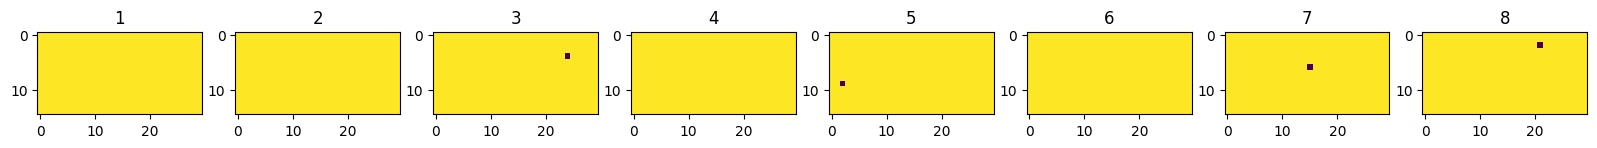

Saving new best model to log/best_model.zip
Num timesteps: 16000
Best mean reward: -99.87 - Last mean reward per episode: -99.87


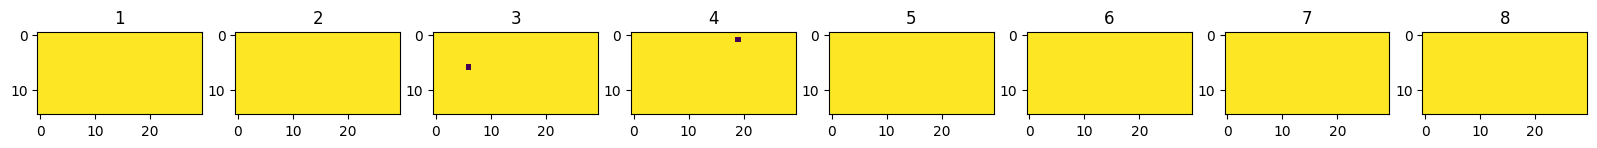

Num timesteps: 24000
Best mean reward: -99.87 - Last mean reward per episode: -100.87


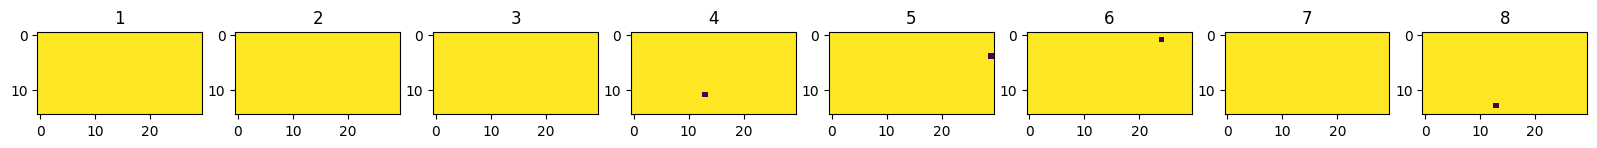

Num timesteps: 32000
Best mean reward: -99.87 - Last mean reward per episode: -100.87


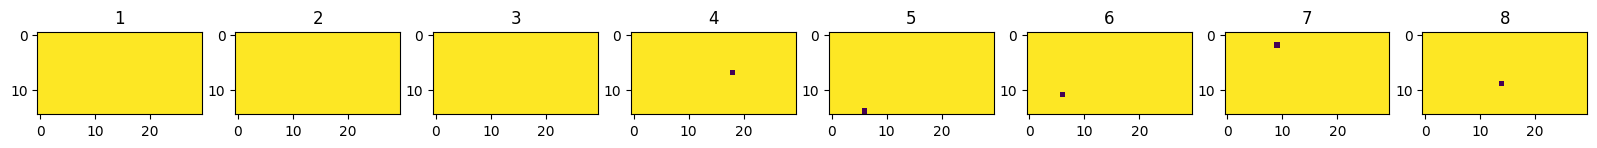

Num timesteps: 40000
Best mean reward: -99.87 - Last mean reward per episode: -99.87


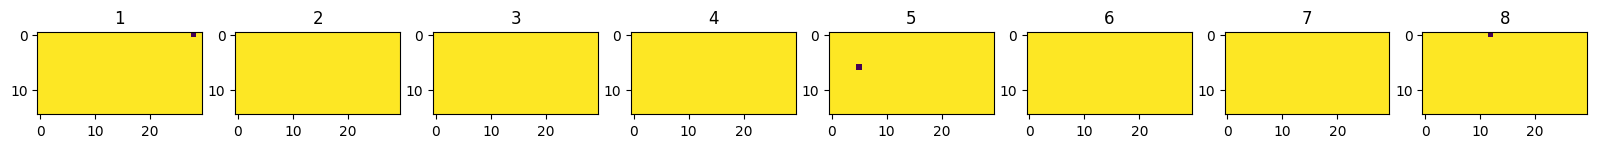

Saving new best model to log/best_model.zip
Num timesteps: 48000
Best mean reward: -99.87 - Last mean reward per episode: -99.87


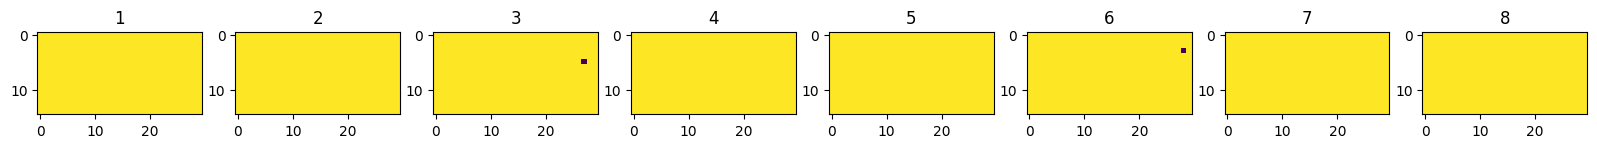

Num timesteps: 56000
Best mean reward: -99.87 - Last mean reward per episode: -99.87


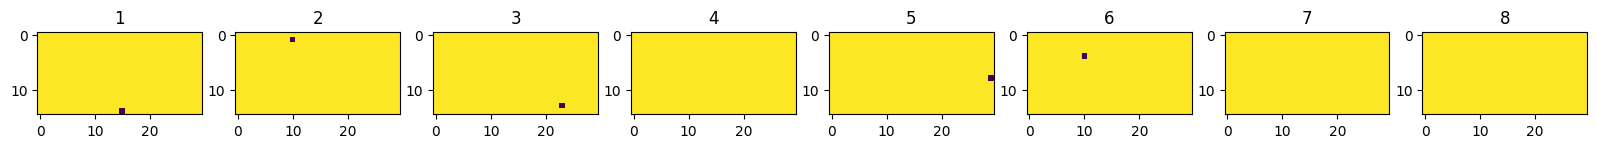

Num timesteps: 64000
Best mean reward: -99.87 - Last mean reward per episode: -100.87


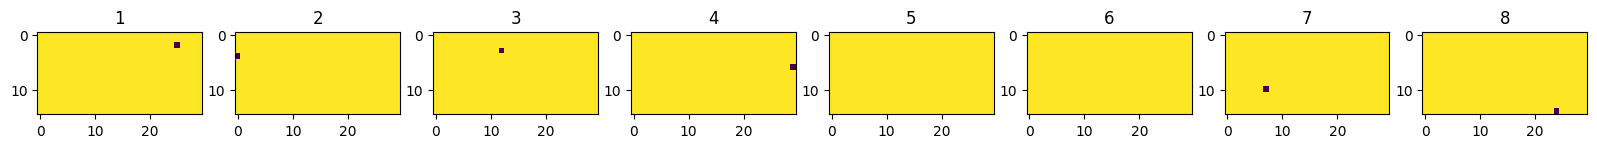

Num timesteps: 72000
Best mean reward: -99.87 - Last mean reward per episode: -99.87


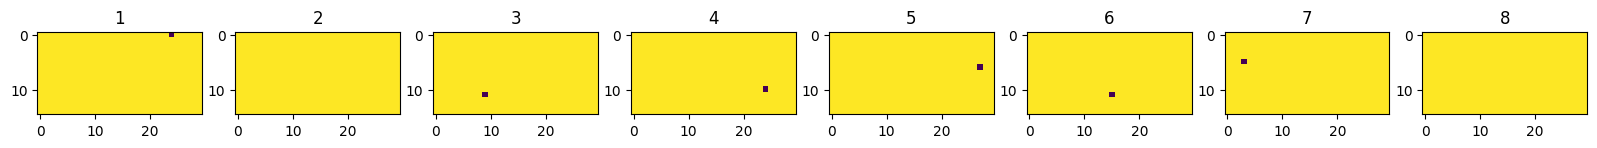

Saving new best model to log/best_model.zip


In [11]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   
print("Elapsed Time = " + str(end-start))

In [ ]:



#env.close()
env = TopOptEnv()
model_best = PPO.load("log/best_model",env=env)
obs, _ = env.reset()
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    action = action.item()
    print(f"Step {i + 1}")
    # print("Action: ", action)       # added Console Outputs for better understanding  
    obs, rewards, dones, _, info = env.step(action)
    if i%10 == 0:
        env.render()
    # if dones:
    #     print("Goal reached!", "reward=", rewards)
    #     break
    i+=1



